In [4]:
import sys
import numpy as np

from pathlib import Path

# Path to the project root (one level up from notebooks folder)
project_root = Path().resolve().parent  # if notebook in /project-root/notebooks

# Add the project root to sys.path if not already present
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    sys.path.append(str("/Users/seydaaybar/Desktop/ntt_data/python_files"))

from python_files.config import CFG
from python_files.helpers import (
    load_selected_data,
    merge_transaction_data,
    check_missing_and_infinite,
    plot_distribution,
    analyze_numeric_column_over_time,
    drop_negative_values,
    drop_columns,
    aggregate_monthly_data,
    create_lstm_sequences,
    time_based_train_val_split,
    create_date_features
)


In [5]:
data = load_selected_data(CFG, ['df'])

df = data['df']
df

,date,shop,item,price,amount,item_name,item_id,item_category_id,item_category_name,shop_name,shop_id
0,02.01.2013,158,122154,3244.0,1.0,PHENOMENON 2012 (BD),122154,1037,Кино - Blu-Ray,"Yaroslavl, TC ""Altair""",158
1,03.01.2013,124,102552,2920.0,1.0,DEEP PURPLE The House Of Blue Light LP,102552,1058,Music - Vinyl,"Moscow, Atrium shopping mall",124
2,06.01.2013,124,102554,5550.0,1.0,DEEP PURPLE Who Do You Think We Are LP,102554,1058,Music - Vinyl,"Moscow, Atrium shopping mall",124
3,15.01.2013,124,102555,3569.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),102555,1056,Music - CD Branded Production,"Moscow, Atrium shopping mall",124
4,10.01.2013,124,102564,1134.0,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,102564,1059,Music - Music Video,"Moscow, Atrium shopping mall",124
...,...,...,...,...,...,...,...,...,...,...,...
2875101,27.09.2015,124,121022,5842.0,1.0,Футболка Batman Arkham Knight Half Batman Half...,121022,1061,Gifts - Merchandise,"Moscow, Atrium shopping mall",124
2875102,19.09.2015,124,121105,5842.0,1.0,Футболка Fallout Laser Gun XL,121105,1061,Gifts - Merchandise,"Moscow, Atrium shopping mall",124
2875103,30.09.2015,124,121088,4219.0,1.0,Diablo III Special Edition T-Shirt Black S,121088,1061,Gifts - Merchandise,"Moscow, Atrium shopping mall",124
2875104,08.09.2015,124,120990,4219.0,1.0,Футболка Assassin's Creed IV Black Flag Animus...,120990,1061,Gifts - Merchandise,"Moscow, Atrium shopping mall",124


##  Aggregate daily data to monthly sales
- Since our prediction target is monthly sales, first sum daily sales into monthly totals per shop-item pair.

In [6]:
import pandas as pd

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['sales'] = df['price'] * df['amount']
df_monthly_cb = aggregate_monthly_data(df, agg_dict={'sales': 'sum'})

/Users/seydaaybar/Desktop/ntt_data/python_files/helpers.py:286: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(group_cols + [pd.Grouper(key=date_col, freq='M')])


In [7]:
df_monthly_cb

,shop_id,item_id,date,sales
0,99,100030,2013-02-28,26691.0
1,99,100031,2013-02-28,15510.0
2,99,100032,2013-01-31,4308.0
3,99,100032,2013-02-28,7180.0
4,99,100033,2013-01-31,3381.0
...,...,...,...,...
1576700,158,122164,2015-04-30,4540.0
1576701,158,122164,2015-07-31,2270.0
1576702,158,122167,2013-10-31,972.0
1576703,158,122167,2013-12-31,1944.0


In [8]:

df_monthly_cb_analysis = df_monthly_cb.groupby('date')['sales'].sum()
print(len(df_monthly_cb_analysis))
max_lags = 33 // 2  

33


In [9]:
df_monthly_cb

,shop_id,item_id,date,sales
0,99,100030,2013-02-28,26691.0
1,99,100031,2013-02-28,15510.0
2,99,100032,2013-01-31,4308.0
3,99,100032,2013-02-28,7180.0
4,99,100033,2013-01-31,3381.0
...,...,...,...,...
1576700,158,122164,2015-04-30,4540.0
1576701,158,122164,2015-07-31,2270.0
1576702,158,122167,2013-10-31,972.0
1576703,158,122167,2013-12-31,1944.0


In [10]:
df_monthly_cb.to_csv('monthly_sales_cb.csv', index=False)

- I didnt use all features ;

    - We must predict monthly sales for each shop-item pair.

    - Our test data only contains shop and item identifiers (no names or categories).

    - Training data has richer info (names, categories), but test data doesn’t.

- I will focus on shop_id and item_id as my core features

## ACF/PACF
- We use ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) in time series analysis to understand the relationship between observations over time, especially when preparing data for modeling
- ACF; Measures correlation between the time series and its lagged values. Helps identify MA (Moving Average) components
- PACF; Measures the direct correlation between a time series and its lag, excluding the effects of intermediate lags. Helps identify AR (AutoRegressive) components.

- So, I will Calculate the ACF of monthly sales for typical shop-item pairs. And, PACF will help identify which lags have direct influence.

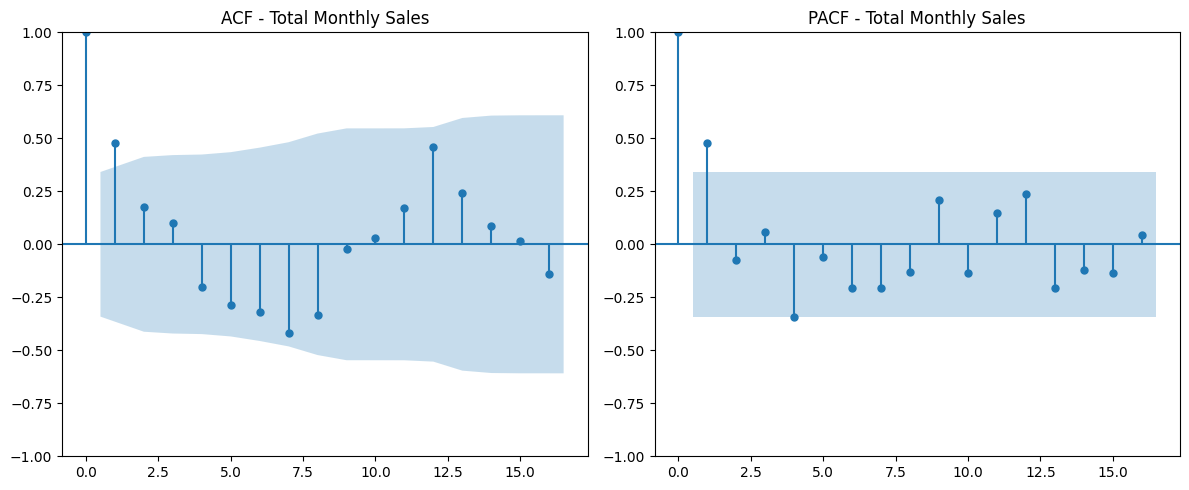

In [66]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

max_lags = 33 // 2  # 16

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(df_monthly_cb_analysis, lags=max_lags, ax=plt.gca())
plt.title('ACF - Total Monthly Sales')

plt.subplot(1, 2, 2)
plot_pacf(df_monthly_cb_analysis, lags=max_lags, ax=plt.gca(), method='ywm')
plt.title('PACF - Total Monthly Sales')

plt.tight_layout()
plt.show()


- ACF shows significant autocorrelation at lags: 1, 2, 5, 6, 7, 12.
- PACF has a clear spike at lag 1 and smaller ones at 4, 10, and 12.

In [11]:

df_monthly = df_monthly_cb.sort_values(['shop_id', 'item_id', 'date'])
for lag in [1, 2, 3, 6, 12]:
    df_monthly[f'lag_{lag}'] = df_monthly.groupby(['shop_id', 'item_id'])['sales'].shift(lag)

df_monthly = df_monthly.dropna()
df_monthly


,shop_id,item_id,date,sales,lag_1,lag_2,lag_3,lag_6,lag_12
8171,101,100482,2014-02-28,10716.0,21432.0,10716.0,21432.0,10716.0,10716.0
8172,101,100482,2014-07-31,10716.0,10716.0,21432.0,10716.0,21432.0,10716.0
8173,101,100482,2014-09-30,21432.0,10716.0,10716.0,21432.0,10716.0,10716.0
8174,101,100482,2014-10-31,10716.0,21432.0,10716.0,10716.0,21432.0,10716.0
8175,101,100482,2015-02-28,42864.0,10716.0,21432.0,10716.0,10716.0,10716.0
...,...,...,...,...,...,...,...,...,...
1576650,158,122092,2014-11-30,1065.0,710.0,2485.0,1420.0,1420.0,2485.0
1576651,158,122092,2014-12-31,1356.0,1065.0,710.0,2485.0,355.0,1065.0
1576652,158,122092,2015-01-31,1421.0,1356.0,1065.0,710.0,2130.0,2485.0
1576653,158,122092,2015-03-31,1746.0,1421.0,1356.0,1065.0,1420.0,1775.0


In [12]:
df_new = create_date_features(df_monthly)
df_new

,shop_id,item_id,date,sales,lag_1,lag_2,lag_3,lag_6,lag_12,month,year,quarter,is_month_start,is_month_end,season
8171,101,100482,2014-02-28,10716.0,21432.0,10716.0,21432.0,10716.0,10716.0,2,2014,1,0,1,0
8172,101,100482,2014-07-31,10716.0,10716.0,21432.0,10716.0,21432.0,10716.0,7,2014,3,0,1,2
8173,101,100482,2014-09-30,21432.0,10716.0,10716.0,21432.0,10716.0,10716.0,9,2014,3,0,1,3
8174,101,100482,2014-10-31,10716.0,21432.0,10716.0,10716.0,21432.0,10716.0,10,2014,4,0,1,3
8175,101,100482,2015-02-28,42864.0,10716.0,21432.0,10716.0,10716.0,10716.0,2,2015,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576650,158,122092,2014-11-30,1065.0,710.0,2485.0,1420.0,1420.0,2485.0,11,2014,4,0,1,3
1576651,158,122092,2014-12-31,1356.0,1065.0,710.0,2485.0,355.0,1065.0,12,2014,4,0,1,0
1576652,158,122092,2015-01-31,1421.0,1356.0,1065.0,710.0,2130.0,2485.0,1,2015,1,0,1,0
1576653,158,122092,2015-03-31,1746.0,1421.0,1356.0,1065.0,1420.0,1775.0,3,2015,1,0,1,1


## Feature Engineering
- i will add rolling mean as new features with this model will understand patterns 
- it gives the model a sense of short-term trend or momentum in the data.
- It's the 3-month moving average of sales for each (shop_id, item_id) pair, shifted by 1 month to avoid data leakage.

In [13]:
df_new = df_new.sort_values(by=['shop_id', 'item_id', 'date'])
df_new['rolling_mean_3'] = df_new.groupby(['shop_id', 'item_id'])['sales'].transform(lambda x: x.shift(1).rolling(3).mean())
df_new =df_new.dropna()


In [14]:
df_new

,shop_id,item_id,date,sales,lag_1,lag_2,lag_3,lag_6,lag_12,month,year,quarter,is_month_start,is_month_end,season,rolling_mean_3
8174,101,100482,2014-10-31,10716.0,21432.0,10716.0,10716.0,21432.0,10716.0,10,2014,4,0,1,3,14288.000000
8175,101,100482,2015-02-28,42864.0,10716.0,21432.0,10716.0,10716.0,10716.0,2,2015,1,0,1,0,14288.000000
8176,101,100482,2015-03-31,10716.0,42864.0,10716.0,21432.0,21432.0,21432.0,3,2015,1,0,1,1,25004.000000
8177,101,100482,2015-07-31,10716.0,10716.0,42864.0,10716.0,10716.0,10716.0,7,2015,3,0,1,2,21432.000000
8178,101,100482,2015-08-31,10716.0,10716.0,10716.0,42864.0,10716.0,21432.0,8,2015,3,0,1,2,21432.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576650,158,122092,2014-11-30,1065.0,710.0,2485.0,1420.0,1420.0,2485.0,11,2014,4,0,1,3,1538.333333
1576651,158,122092,2014-12-31,1356.0,1065.0,710.0,2485.0,355.0,1065.0,12,2014,4,0,1,0,1420.000000
1576652,158,122092,2015-01-31,1421.0,1356.0,1065.0,710.0,2130.0,2485.0,1,2015,1,0,1,0,1043.666667
1576653,158,122092,2015-03-31,1746.0,1421.0,1356.0,1065.0,1420.0,1775.0,3,2015,1,0,1,1,1280.666667


- to have infor  of Direction and strength of recent change, i create trend_1_2
- This captures the difference in sales between the last month and the month before that
- Relative change rate lag_1_ratio_2
- This captures the relative change or ratio between the most recent month's sales and the month before that

In [15]:
df_new['trend_1_2'] = df_new['lag_1'] - df_new['lag_2']
df_new['lag_1_ratio_2'] = df_new['lag_1'] / (df_new['lag_2'] + 1)
df_new

,shop_id,item_id,date,sales,lag_1,lag_2,lag_3,lag_6,lag_12,month,year,quarter,is_month_start,is_month_end,season,rolling_mean_3,trend_1_2,lag_1_ratio_2
8174,101,100482,2014-10-31,10716.0,21432.0,10716.0,10716.0,21432.0,10716.0,10,2014,4,0,1,3,14288.000000,10716.0,1.999813
8175,101,100482,2015-02-28,42864.0,10716.0,21432.0,10716.0,10716.0,10716.0,2,2015,1,0,1,0,14288.000000,-10716.0,0.499977
8176,101,100482,2015-03-31,10716.0,42864.0,10716.0,21432.0,21432.0,21432.0,3,2015,1,0,1,1,25004.000000,32148.0,3.999627
8177,101,100482,2015-07-31,10716.0,10716.0,42864.0,10716.0,10716.0,10716.0,7,2015,3,0,1,2,21432.000000,-32148.0,0.249994
8178,101,100482,2015-08-31,10716.0,10716.0,10716.0,42864.0,10716.0,21432.0,8,2015,3,0,1,2,21432.000000,0.0,0.999907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576650,158,122092,2014-11-30,1065.0,710.0,2485.0,1420.0,1420.0,2485.0,11,2014,4,0,1,3,1538.333333,-1775.0,0.285599
1576651,158,122092,2014-12-31,1356.0,1065.0,710.0,2485.0,355.0,1065.0,12,2014,4,0,1,0,1420.000000,355.0,1.497890
1576652,158,122092,2015-01-31,1421.0,1356.0,1065.0,710.0,2130.0,2485.0,1,2015,1,0,1,0,1043.666667,291.0,1.272045
1576653,158,122092,2015-03-31,1746.0,1421.0,1356.0,1065.0,1420.0,1775.0,3,2015,1,0,1,1,1280.666667,65.0,1.047163


In [16]:
X = df_new.drop(columns=['sales', 'date'])
y = df_new['sales']

In [88]:
X_train, y_train, X_val, y_val = time_based_train_val_split(X, y, val_ratio=0.2)
X_train.to_csv('X_train_catboost.csv', index=False)
y_train.to_csv('y_train_catboost.csv', index=False)
X_val.to_csv('X_val_catboost.csv', index=False)
y_val.to_csv('y_val_catboost.csv', index=False)


In [89]:
X_train

,shop_id,item_id,lag_1,lag_2,lag_3,lag_6,lag_12,month,year,quarter,is_month_start,is_month_end,season,rolling_mean_3,trend_1_2,lag_1_ratio_2
8174,101,100482,21432.0,10716.0,10716.0,21432.0,10716.0,10,2014,4,0,1,3,14288.000000,10716.0,1.999813
8175,101,100482,10716.0,21432.0,10716.0,10716.0,10716.0,2,2015,1,0,1,0,14288.000000,-10716.0,0.499977
8176,101,100482,42864.0,10716.0,21432.0,21432.0,21432.0,3,2015,1,0,1,1,25004.000000,32148.0,3.999627
8177,101,100482,10716.0,42864.0,10716.0,10716.0,10716.0,7,2015,3,0,1,2,21432.000000,-32148.0,0.249994
8178,101,100482,10716.0,10716.0,42864.0,10716.0,21432.0,8,2015,3,0,1,2,21432.000000,0.0,0.999907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282179,151,105821,2108.0,4216.0,6324.0,12648.0,3892.0,10,2014,4,0,1,3,4216.000000,-2108.0,0.499881
1282180,151,105821,10380.0,2108.0,4216.0,8432.0,8432.0,11,2014,4,0,1,3,5568.000000,8272.0,4.921764
1282181,151,105821,12975.0,10380.0,2108.0,2108.0,4216.0,12,2014,4,0,1,0,8487.666667,2595.0,1.249880
1282182,151,105821,15570.0,12975.0,10380.0,6324.0,4216.0,1,2015,1,0,1,0,12975.000000,2595.0,1.199908


## LSTM

In [37]:
df.head()

,date,price,amount,item_id,item_category_id,shop_id,sales
0,2013-01-02,3244.0,1.0,122154,1037,158,3244.0
1,2013-01-03,2920.0,1.0,102552,1058,124,2920.0
2,2013-01-06,5550.0,1.0,102554,1058,124,5550.0
3,2013-01-15,3569.0,1.0,102555,1056,124,3569.0
4,2013-01-10,1134.0,1.0,102564,1059,124,1134.0


- item_name is a textual representation of the item and is highly correlated with item_id, item_name would require complex text processing
- The item_category_id is already represented by item_category_name, which is a more interpretable categorical feature.
- Similar to item_name, shop_name is a textual feature that is directly associated with shop_id

Therefore, we drop item_name, item_category_id, shop_name

- Dropping these columns helps:

    - Reduce feature redundancy

    - Avoid unnecessary complexity in feature engineering

    - Keep the model input clean and efficient

In [38]:
df = drop_columns(df, ['item_name', 'item_category_name', 'shop_name', 'shop', 'item'])
df

,date,price,amount,item_id,item_category_id,shop_id,sales
0,2013-01-02,3244.0,1.0,122154,1037,158,3244.0
1,2013-01-03,2920.0,1.0,102552,1058,124,2920.0
2,2013-01-06,5550.0,1.0,102554,1058,124,5550.0
3,2013-01-15,3569.0,1.0,102555,1056,124,3569.0
4,2013-01-10,1134.0,1.0,102564,1059,124,1134.0
...,...,...,...,...,...,...,...
2875101,2015-09-27,5842.0,1.0,121022,1061,124,5842.0
2875102,2015-09-19,5842.0,1.0,121105,1061,124,5842.0
2875103,2015-09-30,4219.0,1.0,121088,1061,124,4219.0
2875104,2015-09-08,4219.0,1.0,120990,1061,124,4219.0


- Price is not stable over time for this shop-item pair — it changes even within the same month.

So, using monthly average price will capture this variation better than a static price.

In [39]:
agg_dict = {
    'amount': 'sum',    
    'price': 'mean',
    'sales': 'sum'
}
df['sales'] = df['price'] * df['amount']

df_monthly_lstm =  aggregate_monthly_data(df, agg_dict=agg_dict)
df_monthly_lstm

/Users/seydaaybar/Desktop/ntt_data/helpers.py:286: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(group_cols + [pd.Grouper(key=date_col, freq='M')])


,shop_id,item_id,date,amount,price,sales
0,99,100030,2013-02-28,31.0,861.0,26691.0
1,99,100031,2013-02-28,11.0,1410.0,15510.0
2,99,100032,2013-01-31,6.0,718.0,4308.0
3,99,100032,2013-02-28,10.0,718.0,7180.0
4,99,100033,2013-01-31,3.0,1127.0,3381.0
...,...,...,...,...,...,...
1576700,158,122164,2015-04-30,2.0,2270.0,4540.0
1576701,158,122164,2015-07-31,1.0,2270.0,2270.0
1576702,158,122167,2013-10-31,1.0,972.0,972.0
1576703,158,122167,2013-12-31,2.0,972.0,1944.0


In [40]:
item_category_lookup = df[['item_id', 'item_category_id']].drop_duplicates()
df_monthly_lstm = df_monthly_lstm.merge(item_category_lookup, on='item_id', how='left')
df_monthly_lstm


,shop_id,item_id,date,amount,price,sales,item_category_id
0,99,100030,2013-02-28,31.0,861.0,26691.0,1040
1,99,100031,2013-02-28,11.0,1410.0,15510.0,1037
2,99,100032,2013-01-31,6.0,718.0,4308.0,1040
3,99,100032,2013-02-28,10.0,718.0,7180.0,1040
4,99,100033,2013-01-31,3.0,1127.0,3381.0,1037
...,...,...,...,...,...,...,...
1576700,158,122164,2015-04-30,2.0,2270.0,4540.0,1037
1576701,158,122164,2015-07-31,1.0,2270.0,2270.0,1037
1576702,158,122167,2013-10-31,1.0,972.0,972.0,1049
1576703,158,122167,2013-12-31,2.0,972.0,1944.0,1049


In [41]:
df_monthly_lstm = drop_negative_values(df_monthly_lstm, ['amount', 'price', 'sales'])

In [42]:
df_monthly_lstm.to_csv("/Users/seydaaybar/Desktop/ntt_data/df_monthly_lstm.csv", index=False)

## ENCODING CAT VARIABLES

- LSTM models cannot work with strings directly
- Label encoding: Converts to zero-based indices (still integers, but just indices)

- We create separate `LabelEncoder` instances for each categorical feature (`shop_id`, `item_id`, `item_category_id`) because:

    - Each column has its own unique categories.
    - Encoding must be independent to avoid mixing category mappings.
    - This ensures the model correctly interprets each feature’s encoded values.

In [43]:
from sklearn.preprocessing import LabelEncoder
import joblib


le_shop = LabelEncoder()
df_monthly_lstm['shop_id_enc'] = le_shop.fit_transform(df_monthly_lstm['shop_id'])
joblib.dump(le_shop, 'le_shop.pkl')

le_item = LabelEncoder()
df_monthly_lstm['item_id_enc'] = le_item.fit_transform(df_monthly_lstm['item_id'])
joblib.dump(le_item, 'le_item.pkl')

le_cat = LabelEncoder()
df_monthly_lstm['item_category_enc'] = le_cat.fit_transform(df_monthly_lstm['item_category_id'])
joblib.dump(le_cat, 'le_cat.pkl')

['le_cat.pkl']

In [44]:
df_monthly_lstm_enc.to_csv("df_monthly_lstm_enc.csv", index=False)

In [45]:
df_monthly_lstm_enc = drop_columns(df_monthly_lstm_enc, ['shop_id', 'item_id', 'item_category_id'])

In [46]:
df_monthly_lstm_enc["price"].min(), df_monthly_lstm_enc["price"].max()

(np.float64(1.0), np.float64(1000000.0))

### Handling Skewness and Outliers in Sales Data

- Due to extreme values and skewness in sales data, we apply log transformation (`log1p`) before scaling. Alternative methods include RobustScaler, outlier capping (winsorization), or more complex power transforms, but log transformation strikes a good balance between simplicity, interpretability, and effectiveness for sales forecasting.
- Price values range widely, so we apply `log1p` transformation followed by standard scaling, just like with sales. This improves model stability and helps capture meaningful price variations over time.

In [47]:
import pandas as pd
df_monthly_lstm_enc['date'] = pd.to_datetime(df_monthly_lstm_enc['date'])

df_monthly_lstm_enc['sales_log'] = np.log1p(df_monthly_lstm_enc['sales'])
df_monthly_lstm_enc['price_log'] = np.log1p(df_monthly_lstm_enc['price'])

In [48]:
df_monthly_lstm_enc.to_csv("df_monthly_lstm_enc2.csv", index=False)

## Scaling

- LSTM models work best when input values are within a smaller, consistent range (like 0 to 1 or standardized around zero).

- Large value ranges can cause:

    - Slow or unstable training.

    - Difficulty for the model to learn meaningful patterns.

- Scaling helps the model converge faster and perform better.



In [49]:
numeric_features = ['amount', 'price_log', 'sales_log']

In [50]:
df_monthly_lstm_enc

,date,amount,price,sales,shop_id_enc,item_id_enc,item_category_enc,sales_log,price_log
0,2013-02-28,3.492692,861.0,26691.0,0,30,40,10.192119,6.759255
1,2013-02-28,1.058492,1410.0,15510.0,0,31,37,9.649305,7.252054
2,2013-01-31,0.449942,718.0,4308.0,0,32,40,8.368461,6.577861
3,2013-02-28,0.936782,718.0,7180.0,0,32,40,8.879194,6.577861
4,2013-01-31,0.084812,1127.0,3381.0,0,33,37,8.126223,7.028201
...,...,...,...,...,...,...,...,...,...
1576700,2015-04-30,-0.036898,2270.0,4540.0,58,21323,37,8.420903,7.727976
1576701,2015-07-31,-0.158608,2270.0,2270.0,58,21323,37,7.727976,7.727976
1576702,2013-10-31,-0.158608,972.0,972.0,58,21326,49,6.880384,6.880384
1576703,2013-12-31,-0.036898,972.0,1944.0,58,21326,49,7.573017,6.880384


In [51]:
df_monthly_lstm_enc = df_monthly_lstm_enc.drop(columns= ["sales", "price"])

In [52]:
df_monthly_lstm_enc

,date,amount,shop_id_enc,item_id_enc,item_category_enc,sales_log,price_log
0,2013-02-28,3.492692,0,30,40,10.192119,6.759255
1,2013-02-28,1.058492,0,31,37,9.649305,7.252054
2,2013-01-31,0.449942,0,32,40,8.368461,6.577861
3,2013-02-28,0.936782,0,32,40,8.879194,6.577861
4,2013-01-31,0.084812,0,33,37,8.126223,7.028201
...,...,...,...,...,...,...,...
1576700,2015-04-30,-0.036898,58,21323,37,8.420903,7.727976
1576701,2015-07-31,-0.158608,58,21323,37,7.727976,7.727976
1576702,2013-10-31,-0.158608,58,21326,49,6.880384,6.880384
1576703,2013-12-31,-0.036898,58,21326,49,7.573017,6.880384


- Why split by date before scaling?
    - Prevent Data Leakage:
    - When you scale features (like sales, price, amount), the scaler learns parameters such as mean and standard deviation.
    - If you fit the scaler on the entire dataset (train + validation), it "sees" future data (validation), leaking information.
    - This artificially improves model performance and invalidates evaluation.

In [53]:
from sklearn.preprocessing import StandardScaler


numeric_features = ['amount', 'price_log', 'sales_log']

train_cutoff = '2015-01-01'
train_df = df_monthly_lstm_enc[df_monthly_lstm_enc['date'] < train_cutoff].copy()
val_df = df_monthly_lstm_enc[df_monthly_lstm_enc['date'] >= train_cutoff].copy()

scaler = StandardScaler()
scaler.fit(train_df[numeric_features])

train_df[numeric_features] = scaler.transform(train_df[numeric_features])
val_df[numeric_features] = scaler.transform(val_df[numeric_features])

df_monthly_lstm_enc.loc[train_df.index, numeric_features] = train_df[numeric_features]
df_monthly_lstm_enc.loc[val_df.index, numeric_features] = val_df[numeric_features]


In [57]:
import joblib

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [55]:
df_monthly_lstm_enc.to_csv("df_monthly_lstm_encfinal.csv", index=False)

## Creating Time Steps
- Based on the Autocorrelation Function (ACF) analysis, significant correlations were observed at lags up to 12 months, indicating that sales from up to one year ago influence the current sales.

- The Partial Autocorrelation Function (PACF) showed spikes at lag 1 and smaller ones at lag 4, 10, and 12 months, confirming that recent and yearly seasonal patterns impact sales

In [36]:
df_monthly_lstm_enc = df_monthly_lstm_enc.sort_values(['shop_id_enc', 'item_id_enc', 'date']) 
df_monthly_lstm_enc

,date,amount,price,sales,shop_id_enc,item_id_enc,item_category_enc,sales_log,price_log
0,2013-02-28,3.492692,861.0,26691.0,0,30,40,2.014386,-0.438664
1,2013-02-28,1.058492,1410.0,15510.0,0,31,37,1.592230,0.055798
2,2013-01-31,0.449942,718.0,4308.0,0,32,40,0.596098,-0.620670
3,2013-02-28,0.936782,718.0,7180.0,0,32,40,0.993303,-0.620670
4,2013-01-31,0.084812,1127.0,3381.0,0,33,37,0.407705,-0.168810
...,...,...,...,...,...,...,...,...,...
1576700,2015-04-30,-0.036898,2270.0,4540.0,58,21323,37,0.636882,0.533327
1576701,2015-07-31,-0.158608,2270.0,2270.0,58,21323,37,0.097982,0.533327
1576702,2013-10-31,-0.158608,972.0,972.0,58,21326,49,-0.561204,-0.317126
1576703,2013-12-31,-0.036898,972.0,1944.0,58,21326,49,-0.022532,-0.317126


In [72]:
X, y = create_lstm_sequences(
    df=df_monthly_lstm_enc,
    window_size=12,            # Number of time steps (months)
    feature_cols=['amount', 'sales_log','price_log', 'shop_id_enc', 'item_id_enc', 'item_category_enc'],  # Features per timestep
    target_col='sales_log'         # What to predict
)

                    

## Splitting Data 

In [73]:
def time_based_train_val_split_np(X, y, val_ratio=0.2):
    n = len(X)
    val_size = int(n * val_ratio)
    train_size = n - val_size

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:]
    y_val = y[train_size:]

    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = time_based_train_val_split_np(X, y, val_ratio=0.2)


In [74]:
X_train

array([[[-1.58608123e-01,  1.30469452e+00,  2.09017600e+00,
          2.00000000e+00,  4.38000000e+02,  7.30000000e+01],
        [-1.58608123e-01,  1.30469452e+00,  2.09017600e+00,
          2.00000000e+00,  4.38000000e+02,  7.30000000e+01],
        [-1.58608123e-01,  1.30469452e+00,  2.09017600e+00,
          2.00000000e+00,  4.38000000e+02,  7.30000000e+01],
        ...,
        [-3.68981225e-02,  1.84372996e+00,  2.09017600e+00,
          2.00000000e+00,  4.38000000e+02,  7.30000000e+01],
        [-1.58608123e-01,  1.30469452e+00,  2.09017600e+00,
          2.00000000e+00,  4.38000000e+02,  7.30000000e+01],
        [-3.68981225e-02,  1.84372996e+00,  2.09017600e+00,
          2.00000000e+00,  4.38000000e+02,  7.30000000e+01]],

       [[-1.58608123e-01,  1.30469452e+00,  2.09017600e+00,
          2.00000000e+00,  4.38000000e+02,  7.30000000e+01],
        [-1.58608123e-01,  1.30469452e+00,  2.09017600e+00,
          2.00000000e+00,  4.38000000e+02,  7.30000000e+01],
        [-1.58608

In [75]:
import numpy as np

np.save('X_train_lstm.npy', X_train)
np.save('y_train_lstm.npy', y_train)
np.save('X_val_lstm.npy', X_val)
np.save('y_val_lstm.npy', y_val)



In [76]:
print("Max X:", np.max(X_train))
print("Min X:", np.min(y_train))
print("Max y:", np.max(X_val))
print("Min y:", np.min(y_val))


Max X: 21326.0
Min X: -5.05778085876837
Max y: 21326.0
Min y: -5.05778085876837
